In [3]:
import cv2 
import os 
import random 
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, Input, MaxPooling2D, Flatten
from tensorflow.keras.metrics import Precision, Recall
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import uuid #for unique names of the images we are capturing through cv2
import math

In [4]:
#setting the memory allocation to the tensorflow so it dosnt go KRAZY
gpus  = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)


In [5]:
#creating the folders 
POS_PATH = os.path.join ('data', 'positive')
NEG_PATH = os.path.join ('data', 'negative')
ANC_PATH = os.path.join ('data', 'anchor')


In [ ]:
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [ ]:

#link for the data set 
#http://vis-www.cs.umass.edu/lfw/


In [ ]:
#uncompressing the data set 
!tar -xf lfw.tgz

In [ ]:
for directory in os.listdir('lfw'): 
    for file in os.listdir(os.path.join('lfw', directory)): 
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [ ]:
#collecting the positive and anchor classes 250x250
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()

    frame = frame[135:135+250,110:110+250, : ]

    if cv2.waitKey(1)& 0XFF == ord('a'):    
        imgename = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgename, frame)

    if cv2.waitKey(1)& 0XFF == ord('p'):
         imgename = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
         cv2.imwrite(imgename, frame)
    
       
    cv2.imshow('image collection', frame)

    if cv2.waitKey(1)& 0XFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()


In [6]:
#preprocessing the data images 
#getting the image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+ r'\*.jpg').take(310)
positive = tf.data.Dataset.list_files(POS_PATH+ r'\*.jpg').take(310)
negative = tf.data.Dataset.list_files(NEG_PATH+ r'\*.jpg').take(310)

In [7]:
#preprocessing
def preprocess (file_path): 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (100, 100))
    img = img/255.0
    return img

In [8]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [9]:
Sample = data.as_numpy_iterator()
Sample.next()
exp = Sample.next()

In [10]:
#building the test and train model 
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [11]:
preprocess_twin(*exp)

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.7745098 , 0.7862745 , 0.7588235 ],
         [0.7627451 , 0.78431374, 0.7558824 ],
         [0.7647059 , 0.7921569 , 0.7607843 ],
         ...,
         [0.36642158, 0.36544117, 0.3497549 ],
         [0.45343137, 0.4377451 , 0.43382353],
         [0.47549018, 0.4715686 , 0.45588234]],
 
        [[0.77181375, 0.7911765 , 0.77181375],
         [0.76617646, 0.7882353 , 0.76593137],
         [0.7561275 , 0.79240197, 0.7620098 ],
         ...,
         [0.37892157, 0.38088235, 0.36421567],
         [0.46813726, 0.45441177, 0.452451  ],
         [0.45833334, 0.45906863, 0.4490196 ]],
 
        [[0.76911765, 0.7921569 , 0.7860294 ],
         [0.7629902 , 0.79534316, 0.782598  ],
         [0.7588235 , 0.79338235, 0.7740196 ],
         ...,
         [0.35784313, 0.35735294, 0.35171568],
         [0.46764705, 0.46568626, 0.46666667],
         [0.44705883, 0.45294118, 0.4480392 ]],
 
        ...,
 
        [[0.27745098, 0.21568628

In [12]:
# building the data pipe line 
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [13]:
#making the training partation (we can use scikit here but i preferd doing manually)
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16) # taked the first 16 samples for trining 
train_data = train_data.prefetch(8) #prefetch the next 8 samples so NN dont get bottleneck


In [14]:
TRS = train_data.as_numpy_iterator()
TRS = TRS.next()
print(len(TRS[0]))
#Shows that the 16 samples are loaded in the Train data

16


In [15]:
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [16]:
#Creating the Validation Partation 
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)


In [17]:
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [18]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [19]:
TRF = test_data.as_numpy_iterator()
TRF = TRF.next()
print(len(TRF[0]))

16



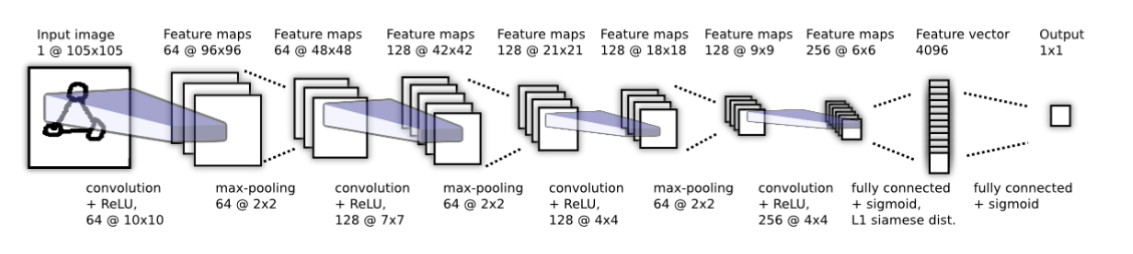

In [20]:
#making the embedding layer 
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=(inp), outputs=(d1), name='embedding')

In [21]:
embedding = make_embedding()

In [22]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

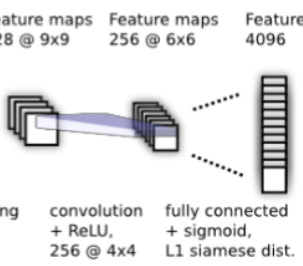

In [23]:
#building the distance layer to calculate the distance between the values of the images that we have 
#converted to the tensors in upper cell so basically there will be two stream of the tensors or 
#numbers and here we are checking the distance between the tensor values 
class L1Dist (Layer): 
    
    def __init__(self, **kwargs): 
        super().__init__()

    def call(self, input_embedding, validation_embedding): 
        return tf.math.abs(input_embedding - validation_embedding)


In [24]:
def make_siamese_model(): 
    #input anchor
    input_image= Input(name='input_img', shape = (100,100,3))

    #validation image 
    validation_image = Input(name='validation_img', shape = (100,100,3))

    #combine the model components
    siamese_layer = L1Dist()
    siamese_layer._name= 'distance'
    distances = siamese_layer(embedding(input_image), embedding (validation_image))
     # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [25]:
siamese_model = make_siamese_model()

In [26]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
#i am aalready late due to some shitty error 
#i was trying to make the siamese model but i was throwning the error that i am passing the list instead of tensors 
#so it is day 4 of building that from paper to code


In [28]:
#setup loss and optimizer 
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [29]:
opt = tf.keras.optimizers.Adam(0.001)#le-4 = 0.0001

In [30]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir ,'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt , siamese_model = siamese_model)

In [31]:
@tf.function
def train_step(batch):
    with tf.GradientTape() as tape:
    #get anchor negitive and positive image 
     X=batch[:2]
     Y=batch[2]
    #forward passs 
     yhat = siamese_model(X,training = True)
     loss = binary_cross_loss(Y, yhat)
    print(loss)
    #calcultae gradiants
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    #UPDATE MODEL 
    opt.apply_gradients(zip(grad,siamese_model.trainable_variables))
    return loss

In [32]:
#training loop 
def train(data,EPOCHS):
    for epoch in range(1, EPOCHS):
        print('\n EPOCH {}/{}'.format(epoch,EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        for idx,batch in enumerate (data): 
            train_step(batch)
            progbar.update(idx+1)
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [33]:
EPOCHS = 30

In [34]:
train(train_data, EPOCHS)


 EPOCH 1/30
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
27/28 ━━━━━━━━━━━━━━━━━━━━ 2s 3s/stepTensor("binary_crossentropy/truediv:0", shape=(), dtype=float32)
28/28 ━━━━━━━━━━━━━━━━━━━━ 74s 3s/step

 EPOCH 2/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 3/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 4/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 5/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 6/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 7/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 8/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step

 EPOCH 9/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 10/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 11/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step

 EPOCH 12/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step

 EPOCH 13/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step

 EPOCH 14/30
28/28 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step

 EPOCH 15/30
28/28 ━━━━━━━━━━━━━━━

In [35]:
#now we are going to evaluate our model 
test_input, test_val, y_true = test_data.as_numpy_iterator().next()


In [36]:
test_var = test_data.as_numpy_iterator().next()

In [37]:
len(test_var)

3

In [38]:
#make pred 
y_hat= siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 986ms/step


In [39]:
y_hat

array([[0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636],
       [0.52075636]], dtype=float32)

In [40]:
print(len(y_hat))
print(len(y_true))

16
16


In [41]:
assert len(y_true) == len(y_hat), "Length of y_true and y_hat must be the same"
assert not np.isnan(y_true).any(), "y_true contains NaN values"
assert not np.isnan(y_hat).any(), "y_hat contains NaN values"
assert not np.isinf(y_true).any(), "y_true contains infinite values"
assert not np.isinf(y_hat).any(), "y_hat contains infinite values"
assert np.min(y_hat) >= 0 and np.max(y_hat) <= 1, "y_hat values should be between 0 and 1"

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_true, y_hat)

# Print the results
print("Thresholds:", thresholds)
print("Precision:", precision)
print("Recall:", recall)

# Find the best threshold based on some criteria, e.g., highest F1-score
f1_scores = 2 * (precision * recall) / (precision + recall)
best_threshold = thresholds[np.argmax(f1_scores)]

print(f"Best Threshold: {best_threshold}")
apx = best_threshold

Thresholds: [0.52075636]
Precision: [0.5 1. ]
Recall: [1. 0.]
Best Threshold: 0.5207563638687134


In [42]:
[1 if prediction >best_threshold else 0 for prediction in y_hat]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [43]:
y_true

array([0., 1., 1., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0.],
      dtype=float32)

In [44]:
m = Recall()
m.update_state(y_true, y_hat)
m.result().numpy()

1.0

In [45]:
p = Precision()
p.update_state(y_true, y_hat)
p.result().numpy()


0.5

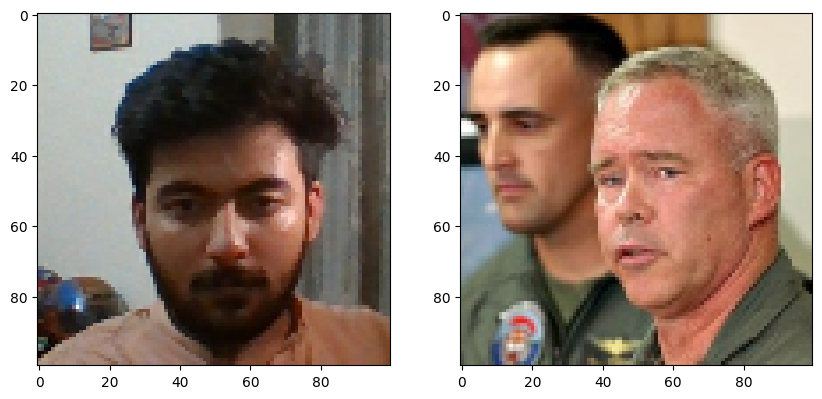

In [46]:

# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[3])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[3])

# Renders cleanly
plt.show()

In [47]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 839ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 844ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 832ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 833ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 840ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1.0 0.46774194


In [48]:
#saving the model
siamese_model.save('siamesemodelv2.h5')

In [49]:
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})



In [ ]:
application_data\verification_images

In [50]:
os.listdir(os.path.join('application_data', 'verification_images'))

['000eac62-5669-11ef-a391-bca8a6e9bbcc.jpg',
 '0155faab-5669-11ef-b5b9-bca8a6e9bbcc.jpg',
 '01a17aac-5669-11ef-891f-bca8a6e9bbcc.jpg',
 '01a68057-5669-11ef-bccf-bca8a6e9bbcc.jpg',
 '02e3d08d-5669-11ef-bc03-bca8a6e9bbcc.jpg',
 '02e8cb0e-5669-11ef-8992-bca8a6e9bbcc.jpg',
 '04c716a0-5669-11ef-a72b-bca8a6e9bbcc.jpg',
 '06a5af3d-5669-11ef-a0ca-bca8a6e9bbcc.jpg',
 '06e6e717-5669-11ef-9d41-bca8a6e9bbcc.jpg',
 '07a137bd-5669-11ef-a8ec-bca8a6e9bbcc.jpg',
 '07ece187-5669-11ef-9969-bca8a6e9bbcc.jpg',
 '09d04f94-5669-11ef-90d5-bca8a6e9bbcc.jpg',
 '0ac6fd5b-5669-11ef-8e5f-bca8a6e9bbcc.jpg',
 '0b1290ca-5669-11ef-8598-bca8a6e9bbcc copy.jpg',
 '0b1290ca-5669-11ef-8598-bca8a6e9bbcc.jpg',
 '0b5e0a89-5669-11ef-97a7-bca8a6e9bbcc.jpg',
 '0b630fb0-5669-11ef-9a31-bca8a6e9bbcc.jpg',
 '0b6815e8-5669-11ef-ad9b-bca8a6e9bbcc.jpg',
 '0c59c3a6-5669-11ef-a394-bca8a6e9bbcc.jpg',
 '0ca56459-5669-11ef-86f7-bca8a6e9bbcc.jpg',
 '0caa5675-5669-11ef-b60c-bca8a6e9bbcc.jpg',
 '0cf106dc-5669-11ef-93f4-bca8a6e9bbcc.jpg',
 '0cf

In [51]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [52]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\000eac62-5669-11ef-a391-bca8a6e9bbcc.jpg
application_data\verification_images\0155faab-5669-11ef-b5b9-bca8a6e9bbcc.jpg
application_data\verification_images\01a17aac-5669-11ef-891f-bca8a6e9bbcc.jpg
application_data\verification_images\01a68057-5669-11ef-bccf-bca8a6e9bbcc.jpg
application_data\verification_images\02e3d08d-5669-11ef-bc03-bca8a6e9bbcc.jpg
application_data\verification_images\02e8cb0e-5669-11ef-8992-bca8a6e9bbcc.jpg
application_data\verification_images\04c716a0-5669-11ef-a72b-bca8a6e9bbcc.jpg
application_data\verification_images\06a5af3d-5669-11ef-a0ca-bca8a6e9bbcc.jpg
application_data\verification_images\06e6e717-5669-11ef-9d41-bca8a6e9bbcc.jpg
application_data\verification_images\07a137bd-5669-11ef-a8ec-bca8a6e9bbcc.jpg
application_data\verification_images\07ece187-5669-11ef-9969-bca8a6e9bbcc.jpg
application_data\verification_images\09d04f94-5669-11ef-90d5-bca8a6e9bbcc.jpg
application_data\verification_images\0ac6fd5b-5669-11ef-8e5f-bca

In [53]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [54]:
# Ensure that you have a 'verify' function defined
def verify(siamese_model, threshold, other_param):
    """
    This function should take the Siamese model and other parameters to perform verification.
    Implement the verification logic here.
    """
    # For demonstration purposes
    # Replace this with actual verification logic
    return "Some results", True

# Set up video capture
cap = cv2.VideoCapture(0)

# Create the directory if it does not exist
os.makedirs(os.path.join('application_data', 'input_image'), exist_ok=True)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    # Crop the frame if needed
    frame = frame[120:120+250, 200:200+250, :]
    
    # Show the frame in a window
    cv2.imshow('Verification', frame)
    
    # Check if the 'v' key is pressed
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save the image to the specified folder
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        
        # Perform verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)
    
    # Check if the 'q' key is pressed to quit
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

True
True
True
